# Poissson Hidden Markov Models

In [1]:
# Set your working directory
import sys
sys.path.insert(0, "../models/")

In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib notebook

In [3]:
from HMM import HMM
from posteriors import gamma, dirichlet, simul_s, _poisson
from simulation import simul_poisson

# We will fit a two component poisson HMM

A 2 components poisson HMM is made of :
* A posterior `gamma` distribution over $\theta = \lambda \in IR^2$
* A posterior distribution over $S \in IR^n$, the states vector; where $n = #obs$
* A posterior `dirichlet` distribution over the transition matrix $P \in IR^{2x2}$

We start by definig the posterior of $ \lambda$

In [4]:
tDictDist = {"_lambda": gamma()}

#Let set the default parameter
tDictDist["_lambda"]._set_default(a = np.array([1, 1/2]))
tDictDist["_lambda"]._set_default(scale = np.array([1/2, 1]))

Now, the **S** distribtuion ...

In [5]:
sDist = simul_s(func = _poisson) # S distribution

Now the $P$ distribution

In [6]:
pDist = dirichlet() # A dirichlet distribution is common for probability vectors
pDist._set_default(a = np.array([[0.5, 0.5], [0.5,0.5]]))

# The poisson mixture on an artificial data

Let's simulate an artificial poisson mixture

In [7]:
P0 = np.array([[0.2, 0.8], [0.6, 0.4]]) # the 'true' transition matrix
theta0 = np.array([1., 10.]) # The true lambdas

(array([307., 111.,  34.,  89., 148., 131.,  93.,  55.,  20.,  12.]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.]),
 <a list of 10 Patch objects>)

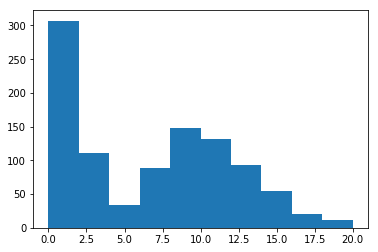

In [8]:
y, SS0 = simul_poisson(P0, theta0, size = 1000) # Simulate 1000 samples of poisson mixtures
plt.hist(y)

In [9]:
Y = y
Theta = {"_lambda" : np.array([5,5])} # Initial lambdas, any !
S = np.random.choice(2, len(Y)) # Initial S, random !
P = np.array([[0.5,0.5],[0.5,0.5]]) # Initial P, any !

In [10]:
phmm = HMM(tDictDist, sDist, pDist, Y=Y, S = S, Theta = Theta, P = P )

In [11]:
np.random.seed(111)
phmm.run(3000) # Start the gibbs sampler n-times

Time : 2019-01-30  23:41:24   Elapsed : 0.00 min.  N_iter : 0000   Remain : 3000   %Remain : 100%
Time : 2019-01-30  23:41:54   Elapsed : 0.50 min.  N_iter : 0500   Remain : 2500   %Remain : 83%
Time : 2019-01-30  23:42:25   Elapsed : 1.02 min.  N_iter : 1000   Remain : 2000   %Remain : 66%
Time : 2019-01-30  23:42:52   Elapsed : 1.47 min.  N_iter : 1500   Remain : 1500   %Remain : 50%
Time : 2019-01-30  23:43:20   Elapsed : 1.94 min.  N_iter : 2000   Remain : 1000   %Remain : 33%
Time : 2019-01-30  23:43:47   Elapsed : 2.39 min.  N_iter : 2500   Remain : 0500   %Remain : 16%


## Checking for auto-correlation in the chain

In [12]:
from utils import plot_ACF

lambdas = np.array([x["_lambda"] for x in phmm.H["Theta"]])

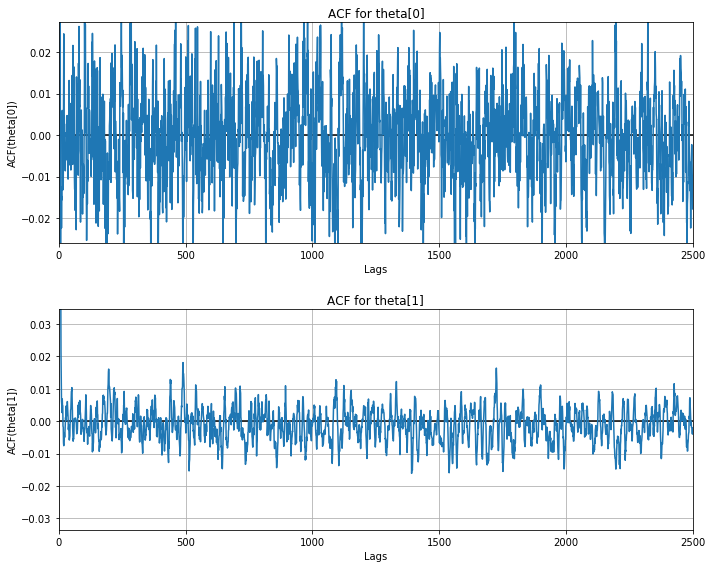

In [13]:
plot_ACF(lambdas, nlags = 2500)

# Can we recover the true clusters ? Let's see !

Text(0.5,1,'Poisson mixture with HMM')

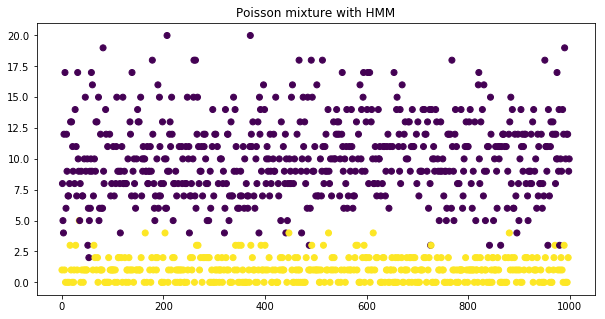

In [14]:
plt.figure(figsize = (10, 5))
plt.scatter(np.arange(len(Y)), Y, c= phmm.S)
plt.title("Poisson mixture with HMM")

In [15]:
(phmm.S == SS0).mean() # Precision or Error rate

0.015

In [16]:
phmm.Theta

{'_lambda': array([10.16763876,  1.12950917])}

In [17]:
_lambda = phmm.tDictDist["_lambda"]
_lambda.params, _lambda.default

({'a': array([5839. ,  455.5]), 'scale': array([0.00173913, 0.00233645])},
 {'a0': 1, 'scale0': 1, 'a': array([1. , 0.5]), 'scale': array([0.5, 1. ])})

In [18]:
_lambda.rvs().round(2) # Our estimates are quite good !!!

array([10.32,  1.1 ])

In [19]:
np.array([history["_lambda"] for history in phmm.H["Theta"][-500::]]).mean(0) # Mean predicted value for _lambda

array([10.11931805,  1.03827119])

In [20]:
np.array(phmm.H["P"][-500::]).mean(0) # Mean transition matrix

array([[0.41407576, 0.58592424],
       [0.79857887, 0.20142113]])